# **Análisis exploratorio**

### *Imports*

In [100]:
# Requeriments
#!pip install pandas
#!pip install numpy
#!pip install readxl
#!pip install matplotlib
#!pip install seaborn
#!pip install scipy

import warnings
warnings.filterwarnings("ignore")

In [99]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

## Información dataset

```{note}
Para el desarrollo de este informe se recolectaron datos de la plataforma SIVIGILA, en el periodo entre los años 2013-2018 sobre el Dengue en Colombia.
Se utilizarán como los datos de entrenamiento para un modelo de clasificación.
El conjunto de datos contiene variables que describen la información clínica de los pacientes, lugar de ocurrencia del caso y el estado de confirmación del caso.

Los datos se encuentran disponibles en:
https://github.com/Darally06/Dengue_class.git

### Lectura de archivos y selección de variables de interes

In [ ]:
# Lectura

data = pd.read_csv("Dengue_entre.csv",dtype={36: str})
# Cambiar ruta de archivo

In [101]:
# Correcion de tipo a DateTime de variables tipo fecha
columnas_fecha = ["FEC_NOT", "FEC_CON", "INI_SIN", "FEC_HOS"]
data[columnas_fecha] = data[columnas_fecha].apply(pd.to_datetime, errors='coerce', dayfirst = True)

#Seleccion de variables de estudio"
columnas = [ "EDAD_AJUSTADA", "SEXO", "TIP_SS", 
            "GP_MIGRANT", "GP_POBICFB", "GP_GESTAN", 
            "AREA", "PAIS_OCU", "DPTO_OCU", "MUN_OCU",
            "SEMANA", "ANO", 
            "EVENTO", "TIP_CAS", "ESTADO_FINAL", "CASO", 
            "PAC_HOS", "CON_FIN", "confirmados",
            "FEC_NOT", "FEC_CON", "INI_SIN", "FEC_HOS"
           ]
df = data[columnas]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500444 entries, 0 to 500443
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   EDAD_AJUSTADA  500420 non-null  float64       
 1   SEXO           500444 non-null  object        
 2   TIP_SS         500444 non-null  object        
 3   GP_MIGRANT     500444 non-null  int64         
 4   GP_POBICFB     500444 non-null  int64         
 5   GP_GESTAN      500444 non-null  int64         
 6   AREA           500444 non-null  int64         
 7   PAIS_OCU       500444 non-null  object        
 8   DPTO_OCU       500444 non-null  object        
 9   MUN_OCU        500444 non-null  object        
 10  SEMANA         500444 non-null  int64         
 11  ANO            500444 non-null  int64         
 12  EVENTO         500444 non-null  object        
 13  TIP_CAS        500444 non-null  int64         
 14  ESTADO_FINAL   492156 non-null  float64       
 15  

```{note}
El dataset cuenta con 500444 registros, de los cuales se seleccionaron 22 variables de interés para el análisis exploratorio.

### Datos NA

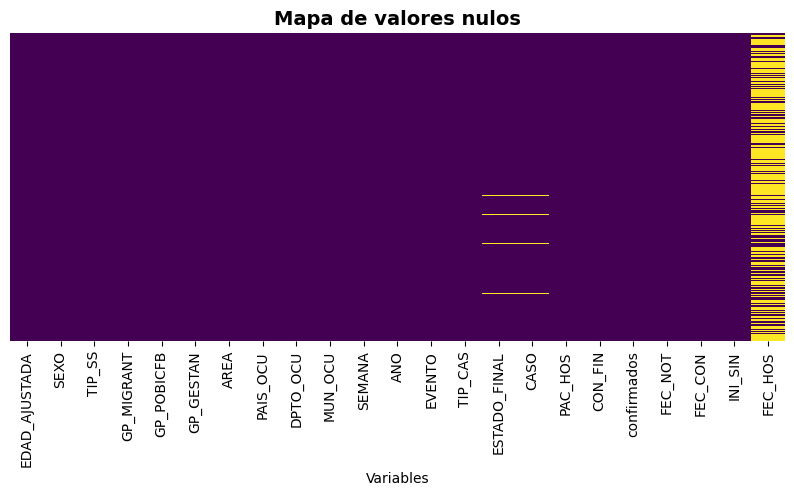

In [ ]:
# Visualización de datos faltantes

plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Distribución de valores nulos en las variables", 
          fontsize=14, fontweight="bold")
plt.xlabel("Variables")
plt.show()

In [55]:
# Conteo de  valores NA

na_counts = df.isna().sum()
na_percent= (na_counts / len(df)) * 100

na_table = pd.DataFrame({
    "Variable": na_counts.index,
    "Cantidad_NA": na_counts.values,
    "Porcentaje_NA": na_percent.values
})
na_table = na_table[na_table["Cantidad_NA"] > 0]
print("Tabla de valores faltantes")
print(na_table)

Tabla de valores faltantes
         Variable  Cantidad_NA  Porcentaje_NA
0   EDAD_AJUSTADA           24       0.004796
14   ESTADO_FINAL         8288       1.656129
15           CASO         8288       1.656129
20        FEC_CON           92       0.018384
21        INI_SIN           53       0.010591
22        FEC_HOS       315803      63.104563


Las variables *"Edad", "Estado final", "Caso", "Fecha consulta", "Fecha inicio de síntomas" y "Fecha hospitalización"*, presentan datos perdidos. En su mayoría el porcentaje de perdida es menor al $5$%, por lo que para efectos del análisis descriptivo no se realizará imputación de datos.

# **Descriptivo de variables**

## *Variables informativas*
Variables para la caracterización de los pacientes

In [56]:
# Sexo
df["SEXO"].value_counts(normalize=True) * 100

SEXO
M    52.495984
F    47.504016
Name: proportion, dtype: float64

La cantidad de pacientes masculinos y femeninos es, equilibrada, siendo un $52.5$% hombres y $47.50$% mujeres

In [57]:
# Tipo de aseguradora
print("Tipo de aseguradora")
df["TIP_SS"].value_counts(normalize=True) * 100

Tipo de aseguradora


TIP_SS
C    48.953329
S    40.877101
N     4.069586
E     2.977356
P     2.797116
I     0.325511
Name: proportion, dtype: float64

La mayor parte de los pacientes ($48.95$)% están afiliados a un carnet de salud contributivo y al carnet subsidiado ($40.87$%).

In [ ]:
# Grupos poblacionales de interes
grupo_cols = ["GP_MIGRANT","GP_GESTAN","GP_POBICFB"]
conteo_grupos = df[grupo_cols].apply(lambda x: (x == 1).sum())
tabla_grupos = pd.DataFrame({"Grupo de Pertenencia": conteo_grupos.index, "Cantidad de Personas": conteo_grupos.values})
print("Pertenencia a grupos de interés")
print(tabla_grupos)

  Grupo de Pertenencia  Cantidad de Personas
0           GP_MIGRANT                  1192
1            GP_GESTAN                  3611
2           GP_POBICFB                   742


In [59]:
# Area de ocurrencia
df["AREA"].value_counts(normalize=True) * 100

AREA
1    81.931645
2     9.087131
3     8.981225
Name: proportion, dtype: float64

La mayoria de los casos ($81.9$%) ocurrieron en cabeceras municipales, un $9.1$% en centros poblados y en menor medida ($8.9$%) en zonas rurales dispersas

## *Edad*
Distribución de la edad y grupos etarios.

```{note}
Para la variable edad se realizó un ajuste dependiendo la unidad de medida registrada. Además, se eliminaron de 19 datos inconsistentes con el resto del conjunto. Los valores registrados en tiempo en meses, semanas o días se tomarán con valor referencial de 1 año.

In [60]:
# Ajuste de edades menores a un año (Representación de en días, semanas o meses, variable que representa años)
df.loc[df["EDAD_AJUSTADA"] < 1, "EDAD_AJUSTADA"] = 1 

Q1 = df["EDAD_AJUSTADA"].quantile(0.25)
Q3 = df["EDAD_AJUSTADA"].quantile(0.75)
IQR = Q3 - Q1


# Descripción
print("Variable edad de los pacientes")
df["EDAD_AJUSTADA"].describe()


Variable edad de los pacientes


count    500420.000000
mean         25.338596
std          19.893978
min           1.000000
25%          10.000000
50%          20.000000
75%          37.000000
max         114.000000
Name: EDAD_AJUSTADA, dtype: float64

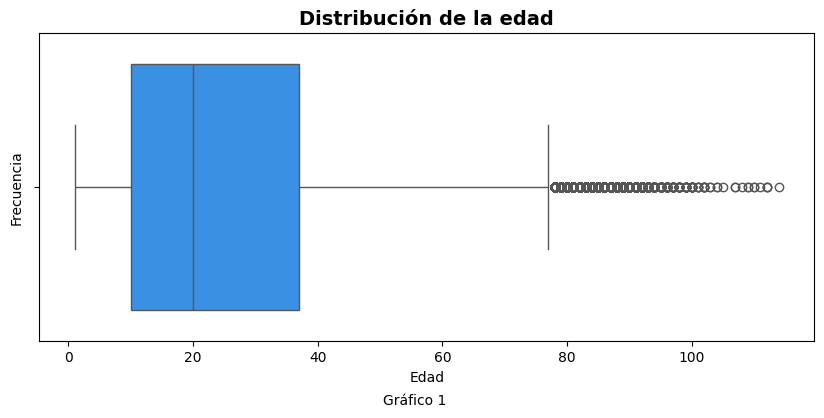

In [61]:
# Gráfico
plt.figure(figsize=(10, 4))
sns.boxplot(x = "EDAD_AJUSTADA", data = df, color = "dodgerblue")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.title("Distribución de la edad", fontsize=14, fontweight="bold")
plt.figtext(0.5, -0.05, "Gráfico 1", ha="center", fontsize=10)
plt.show()

In [62]:
# Valor de asimetria
skewness = stats.skew(df['EDAD_AJUSTADA'].dropna())
print(f"Valor de asimetría: {skewness}")

Valor de asimetría: 0.9483503997968334


En el *gráfico 1* se presenta la distribución de la edad de los pacientes. La edad varia  entre $1$ y $114$ años, con una media de $25$ años ($ \pm 19.9$). La mayor ocurrencia de casos se encuentra entre los $10$ y $37$ años. Se observan datos atípicos después de los $77$ años, con casos puntuales de representación de personas con edad avanzada. La distribución de la edad presenta alto valor de asimetría positiva.

### Grupo de edad menores a 5 años

In [63]:
# Menores de 5 años
menores = df[df["EDAD_AJUSTADA"] <= 5]

# Tabla
tabla_age = pd.DataFrame({
    "Edad": menores["EDAD_AJUSTADA"].value_counts().index,
    "Pacientes": menores["EDAD_AJUSTADA"].value_counts().values,
})
tabla_age["Porcentaje"] = round((tabla_age["Pacientes"] / tabla_age["Pacientes"].sum()) * 100, 3)
print("Distribución edad de los pacientes")
print(tabla_age)


Distribución edad de los pacientes
   Edad  Pacientes  Porcentaje
0   1.0      24917      36.245
1   5.0      12202      17.749
2   4.0      11444      16.647
3   3.0      10412      15.146
4   2.0       9771      14.213


En el grupo etario de menores a 5 años, en su mayoría (36.34%) tienen 1 año. 

C:\Users\danie\AppData\Local\Temp\ipykernel_15072\240503222.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["1", "2", "3", "4", "5"])


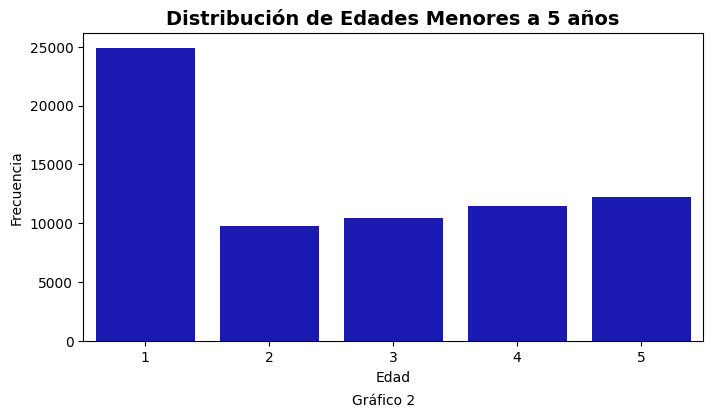

In [64]:
#Gráfico
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=menores["EDAD_AJUSTADA"], color="mediumblue")
plt.title("Distribución de Edades Menores a 5 años",fontsize=14, fontweight="bold")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
ax.set_xticklabels(["1", "2", "3", "4", "5"])
plt.figtext(0.5, -0.05, "Gráfico 2", ha="center", fontsize=10)
plt.show()


En el *Gráfico 2*, se muestra la distribución de casos para pacientes menores a $5$ años.

### Grupo de edad mayores a 65 años

In [65]:
# Mayores de 65 años
mayores = df[df["EDAD_AJUSTADA"] >= 65]
#mayores["EDAD_AJUSTADA"].describe()

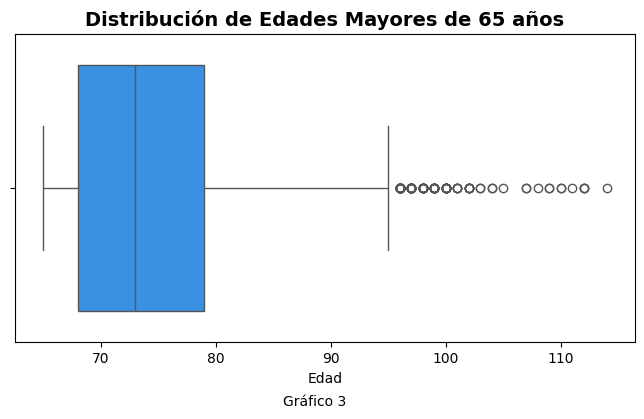

In [66]:
#Gráfico
plt.figure(figsize=(8, 4))
sns.boxplot(x=mayores["EDAD_AJUSTADA"], color="dodgerblue")
plt.title("Distribución de Edades Mayores de 65 años", fontsize=14, fontweight="bold")
plt.xlabel("Edad")
plt.figtext(0.5, -0.05, "Gráfico 3", ha="center", fontsize=10)
plt.show()

En el *gráfico 3*, diagrama de cajas y bigotes, se muestra la distribución de edad de los pacientes **mayores a $65$ años**. El $50%$ central de los datos se encuentra entre los $68$ y $79$ años. A partir de los $95$ años, se observan valores atípicos, correspondientes a pacientes de avanzada edad.

## *Lugar de ocurrencia*
Ubiciación geográfica de la ocurrencia del caso

### Departamentos

In [67]:
# Tabla
tabla_dptos = pd.DataFrame({
    "Departamento": df["DPTO_OCU"].value_counts().nlargest(10).index,
    "Casos": df["DPTO_OCU"].value_counts().nlargest(10).values,
})
print("Top 10 departamentos de mayor ocurrencia")
print(tabla_dptos)

Top 10 departamentos de mayor ocurrencia
      Departamento  Casos
0            VALLE  86298
1        ANTIOQUIA  55248
2        SANTANDER  50337
3           TOLIMA  42990
4             META  31442
5  NORTE SANTANDER  29661
6        ATLANTICO  24657
7            HUILA  23393
8     CUNDINAMARCA  18600
9            CESAR  16456


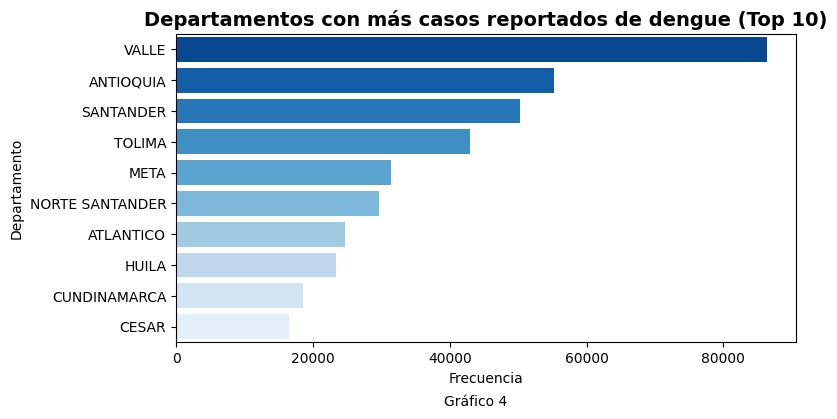

In [102]:
# Gráfico
plt.figure(figsize=(8, 4))
df_filtered = df["DPTO_OCU"].value_counts().nlargest(10)
sns.barplot(
    x=df_filtered.values, 
    y=df_filtered.index, 
    palette="Blues_r",  hue = df_filtered.index,
    saturation=1)
plt.title("Departamentos con más casos reportados de dengue (Top 10)", 
          fontsize=14, fontweight="bold")
plt.xlabel("Frecuencia")
plt.ylabel("Departamento")
plt.figtext(0.5, -0.05, "Gráfico 4", ha="center", fontsize=10)
plt.show()

En el *gráfico 4*, el diagrama de barras presenta los **10 departamentos con mayor número de casos de Dengue en Colombia**. Valle del Cauca encabeza la lista con $86,298$ casos, seguido de Antioquia $55,248$ y Santander $50,337$.
Por otro lado, los departamentos con menor cantidad de casos reportados son Vaupés $54)$, San Andrés $(433)$, Guaina $(543)$, Vichada $(838)$ y los procedentes del exterior $(906)$.

```{note}
Para el análisis demográfico, se han tomado los datos proporcionados por el censo poblacional del DANE (2018) para referenciar la cantidad de casos por población.

In [69]:
# Cargado datos
deptos = pd.read_excel(r"C:\Users\danie\Dengue\Dengue_fill\Datos\poblacion_departamentos.xlsx")
deptos["Población"] = deptos["Población"].astype("Int64")

In [70]:
# Contar los casos por departamento
casos_por_dpto = df["DPTO_OCU"].value_counts().reset_index()
casos_por_dpto.columns = ["Departamento", "Casos"]

df_final = pd.merge(casos_por_dpto, deptos, on="Departamento", how="left")

# Calcular la densidad de casos por 10,000 habitantes
df_final["Densidad_Casos"] = (df_final["Casos"] / df_final["Población"]) * 100000
df_final = df_final.sort_values(by="Densidad_Casos", ascending=False)

In [71]:
# Filtrar los 10 departamentos con mayor densidad de casos
df_top10 = df_final.nlargest(10, "Densidad_Casos")
print("Departamentos con mayor densidad de casos")
print(df_top10)

Departamentos con mayor densidad de casos
       Departamento  Casos  Población  Densidad_Casos
24         GUAVIARE   2566      73081     3511.172535
3            TOLIMA  42990    1228763     3498.640503
4              META  31442     919129     3420.847346
14         CASANARE  10244     379892     2696.555863
16         PUTUMAYO   7347     283197     2594.307143
2         SANTANDER  50337    2008841     2505.773229
13          QUINDIO  12621     509640     2476.453968
7             HUILA  23393    1009548     2317.175607
0             VALLE  86298    3789874     2277.067786
5   NORTE SANTANDER  29661    1346806     2202.321641


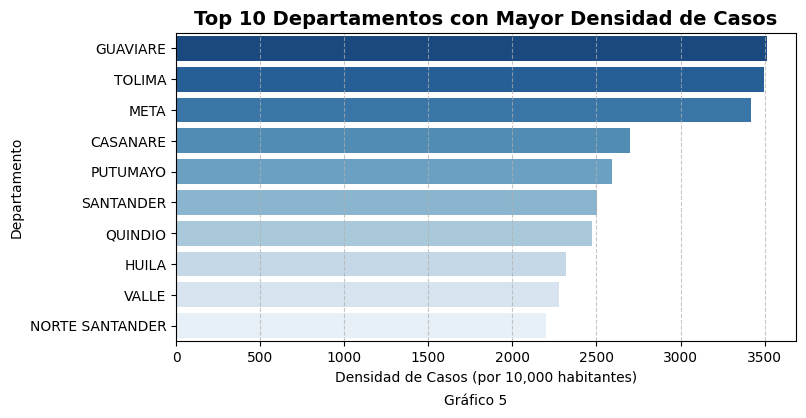

In [72]:
# Gráficar
plt.figure(figsize=(8, 4))
sns.barplot(y=df_top10["Departamento"], x=df_top10["Densidad_Casos"], hue = df_top10["Departamento"], palette="Blues_r")
plt.xlabel("Densidad de Casos (por 10,000 habitantes)")
plt.ylabel("Departamento")
plt.title("Top 10 Departamentos con Mayor Densidad de Casos", fontsize=14, fontweight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.figtext(0.5, -0.05, "Gráfico 5", ha="center", fontsize=10)
plt.show()

El *gráfico 5*, el diagrama de barras representa los departamentos con **mayor densidad de casos por cada $100,000$ habitantes**. Guaviare es el departamento la densidad más alta $(351.12)$ casos, seguido por Tolima $(349.86)$ y Meta $(342.08)$.

Es importante destacar que Guaviare, a pesar de tener a población baja ($72,081$ habitantes), registra la mayor densidad de casos.\
Por otro lado, Tolima y Meta, no solo están entre los 10 departamentos con mayor cantidad de casos totales, sino que tambin presentan alta carga de casos en relación con su población.\
Finalmente, Casanare y Putumayo, a pesar de contar con una población relativamente baja, también presentan altos índices de densidad de casos.

### Municipios

In [73]:
tabla_mun = pd.DataFrame({
    "Mayor ocurrencia": df["MUN_OCU"].value_counts().nlargest(10).index,
    "Casos": df["MUN_OCU"].value_counts().nlargest(10).values,
})
print("Top 10 municipios de mayor ocurrencia")
print(tabla_mun)

Top 10 municipios de mayor ocurrencia
  Mayor ocurrencia  Casos
0             CALI  62954
1         MEDELLIN  29978
2           IBAGUE  17503
3           CUCUTA  16361
4    VILLAVICENCIO  15634
5      BUCARAMANGA  15602
6     BARRANQUILLA  11274
7            NEIVA  10405
8    FLORIDABLANCA   9245
9        SINCELEJO   7839


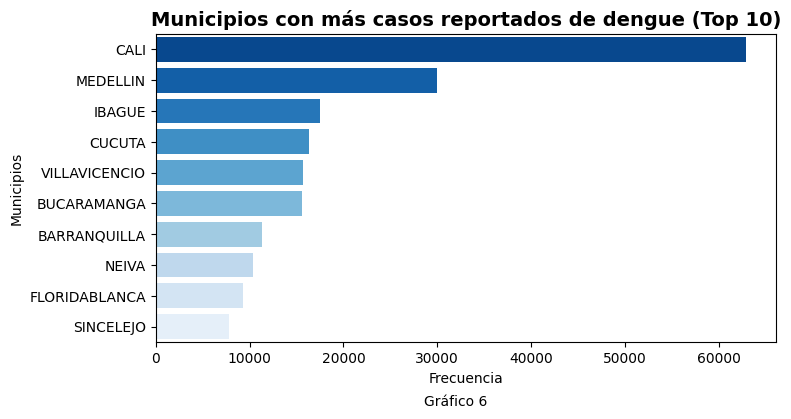

In [104]:
# Gráfico
plt.figure(figsize=(8, 4))
df_filtered_mun = df["MUN_OCU"].value_counts().nlargest(10)
sns.barplot( x = df_filtered_mun.values, y = df_filtered_mun.index,
            palette="Blues_r", hue = df_filtered_mun.index, saturation=1)
plt.title("Municipios con más casos reportados de dengue (Top 10)", fontsize=14, fontweight="bold")
plt.xlabel("Frecuencia")
plt.ylabel("Municipios")
plt.figtext(0.5, -0.05, "Gráfico 6", ha="center", fontsize=10)
plt.show()

En el *gráfico 4*, el diagrama de barras presenta los **10 municipios con mayor número de casos de Dengue en Colombia**. Cali es la ciudad con el mayor número de casos reportados, con $62,954$ observaciones, seguida por Medellín $29,978$ e Ibagué $17,503$, con una diferencia significativa respecto a la primera.

## *Semana*
Registro por semana epidemiológica en Colombia

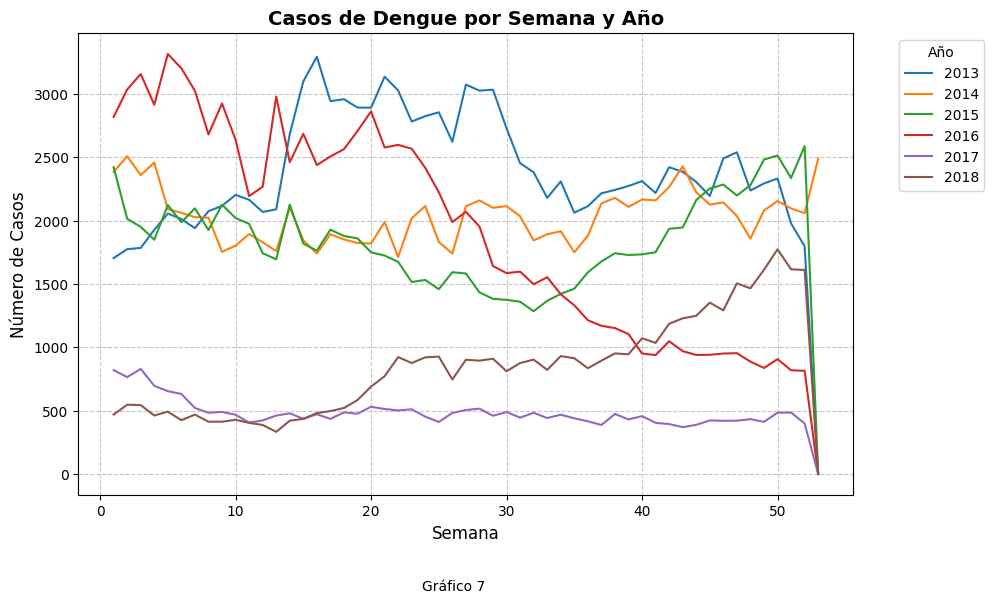

In [94]:
# Semanas
# Agrupar los casos por año
conteo_semanal_anual = df.groupby(["ANO", "SEMANA"]).size().unstack(level=0, fill_value=0)

plt.figure(figsize=(10, 6))
for año in conteo_semanal_anual.columns:
    plt.plot(conteo_semanal_anual.index, conteo_semanal_anual[año], linestyle="-", label=str(año))
plt.title("Casos de Dengue por Semana y Año", fontsize=14, fontweight="bold")
plt.xlabel("Semana", fontsize=12)
plt.ylabel("Número de Casos", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Año", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.figtext(0.5, -0.05, "Gráfico 7", ha="center", fontsize=10)
plt.show()

El *gráfico 7*, muestra la distribución de **casos por semana para cada año estudiado**.\
En **2016**, los casos registrados muestran una tendencia a la baja a lo largo del año. En contraste, en **2018**, los casos aumentaron con el transcurso de las semanas.\
Los años **2013** y **2014** presentan mayor número de casos reportados por semana, mientras que **2015** se caracteriza por una alta fluctuación en el número de casos semanales. \
Por otro lado, **2017** fue el año con menor número de casos registrados.
ienen mayor reporte de casos por semana. En el año 2015 los casos por semanas son los que tienen mayor fluctiación y **el 2017 fue el año con menor registro de datos**.

In [76]:
# tabla
tabla_semana = pd.DataFrame({
    "Semana": df["SEMANA"].value_counts().nlargest(10).index,
    "Casos": df["SEMANA"].value_counts().nlargest(10).values,
}).sort_values(by="Semana") 
print("Top 10 de Semanas con mayor ocurrencia")
print(tabla_semana)

Top 10 de Semanas con mayor ocurrencia
   Semana  Casos
4       1  10620
2       2  10647
3       3  10628
0       5  10732
8       6  10323
9      15  10322
7      19  10345
5      20  10546
1      21  10714
6      22  10440


Las semanas con *mayor cantidad de casos* reportados se encuentran entre la semana 1 y la 6, así como en la semana 19 y la 22.
Por otro lado, las semanas con *menor notificación de casos* corresponden al periodo entre la semana 32 y la 41.

## *Evento*
Clasificación entre Dengue y Dengue grave

In [ ]:
# Tabla
tabla_eve = pd.DataFrame({
    "Evento": df["EVENTO"].value_counts().index,
    "Pacientes": df["EVENTO"].value_counts().values,
})
tabla_eve["Porcentaje"] = round((tabla_eve["Pacientes"] / tabla_eve["Pacientes"].sum()) * 100, 3)
print("Distribución de eventos")
print(tabla_eve)

         Evento  Pacientes  Porcentaje
0        DENGUE     491637       98.24
1  DENGUE GRAVE       8807        1.76


Solo el $1.76$% de los casos es catalogado como Dengue grave.

### Evento por años

In [78]:
# Pacientes por evento, por año
tabla_eve_year = df.groupby("ANO")["EVENTO"].value_counts().unstack().fillna(0)
print("Cantidad de eventos por año")
print(tabla_eve_year)

Cantidad de eventos por año
EVENTO  DENGUE  DENGUE GRAVE
ANO                         
2013    122441          3113
2014    105356          2619
2015     95023          1421
2016    100117           899
2017     25048           236
2018     43652           519


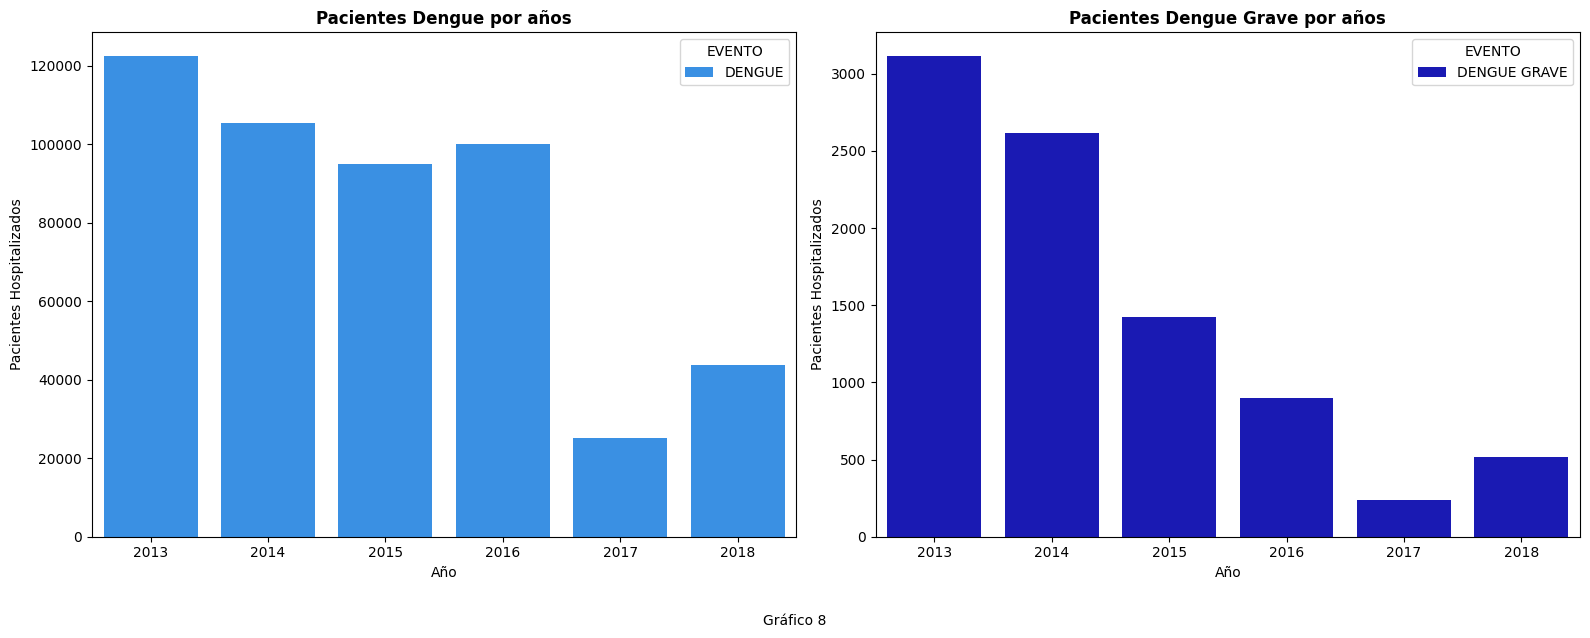

In [95]:
#Grafico evento por años

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# DENGUE
df_d = df[df['EVENTO'] == "DENGUE"]
sns.countplot(x="ANO", data=df_d, hue="EVENTO", palette=["dodgerblue"], ax=axes[0])
axes[0].set_title("Pacientes Dengue por años", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Año")
axes[0].set_ylabel("Pacientes Hospitalizados")

#DENGUE GRAVE
df_g = df[df['EVENTO'] == "DENGUE GRAVE"]
sns.countplot(x="ANO", data=df_g, hue="EVENTO", palette=["mediumblue"], ax=axes[1])
axes[1].set_title("Pacientes Dengue Grave por años", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Año")
axes[1].set_ylabel("Pacientes Hospitalizados")

plt.figtext(0.5, -0.05, "Gráfico 8", ha="center", fontsize=10)
plt.tight_layout()
plt.show()

En el *gráfico 8* se presenta la cantidad de pacientes hospitalizados por Dengue y Dengue Grave en Colombia, a lo largo de los años $2013$ a $2018$. Para el Evento Dengue grave, del $2013$ a $2017$, la cantidad de pacientes sigue una tendencia decreciente.


### Decesos por evento

In [80]:
# Descensos por evento
df_decesos = df[df["CON_FIN"] == 2]  
tabla_decesos = df_decesos["EVENTO"].value_counts().reset_index()
tabla_decesos.columns = ["Evento", "Decesos"]
print("Cantidad de decesos por evento")
print(tabla_decesos)

Cantidad de decesos por evento
         Evento  Decesos
0  DENGUE GRAVE      239
1        DENGUE       14


Solo el $0.05$% de los pacientes murieron a causa de la enfermedad.

## *Estado del caso*
Estado de confirmación del caso por parciente: probable, confirmado por laboratorio, confirmado por nexo epidemiologico.
Variable al inicio y al final del registro de notificación.

In [81]:
tabla_caso = pd.DataFrame({
    "Nombre del Caso": df["CASO"].value_counts().index,
    "Caso inicial": df["TIP_CAS"].value_counts().values,
    "Caso final": df["ESTADO_FINAL"].value_counts().values,
})
print("Estado del caso")
print(tabla_caso)

Estado del caso
                      Nombre del Caso  Caso inicial  Caso final
0                            Probable        386002      260957
1          Confirmado por laboratorio        108799      205010
2  Confirmado por Nexo Epidemiológico          5643       26189


In [82]:
est_year = df.groupby("CASO")["ANO"].value_counts().unstack().fillna(0)
print("Confirmación de casos por año")
print(est_year)

Confirmación de casos por año
ANO                                  2013   2014   2015   2016   2017   2018
CASO                                                                        
Confirmado por Nexo Epidemiológico   4491   5254   5996   7022   1306   2120
Confirmado por laboratorio          57641  46357  32330  40931   6399  21352
Probable                            60309  53745  56697  52164  17343  20699


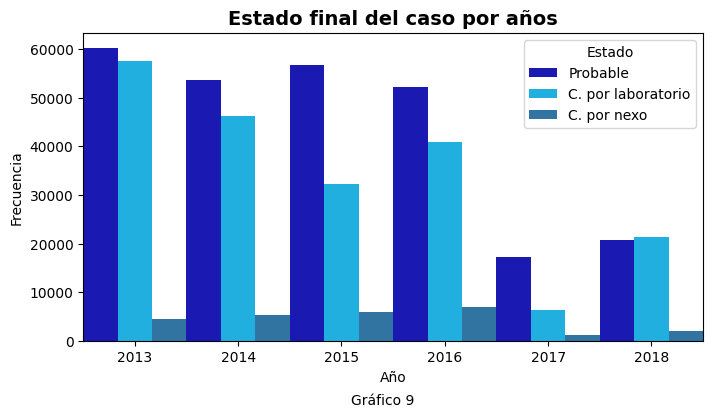

In [83]:
# Gráfico
plt.figure(figsize=(8, 4))
sns.countplot(data = df, x= "ANO", hue="ESTADO_FINAL", palette=["mediumblue", "deepskyblue", "#1f77b4"], width= True)
plt.title("Estado final del caso por años", fontsize=14, fontweight="bold")
plt.ylabel("Frecuencia")
plt.xlabel("Año")
plt.legend(title="Estado", labels = ["Probable", "C. por laboratorio", "C. por nexo"])
plt.figtext(0.5, -0.05, "Gráfico 9", ha="center", fontsize=10)
plt.show()

El *gráfico 9* muestra la distribución del estado final de los casos de Dengue en Colombia entre el 2013 y 2018, diferenciando entre los casos probables, confirmados por laboratorio y confirmados por nexo epidemiológico. Se observa entre el $2013$ y $2016$, predominan los casos probables y confirmados por laboratorio, con una disminución significativa en $2017$, año con el menor número de registros. En $201$, los casos confirmados por laboratorio superan ligeramente a los probables. Los casos confirmado por nexo se mantienen en una proporción baja a lo largo de los años, creciente entre el $2013$ y $2016$.

## *Confirmados*
Confirmación de casos por año: (1) Confirmados (0) No confirmado (0)

In [84]:
tabla_conf= pd.DataFrame({
    "Confirmados": df["confirmados"].value_counts().index,
    "Pacientes": df["confirmados"].value_counts().values,
})
print("Cantidad de casos confirmados")
print(tabla_conf)

Cantidad de casos confirmados
   Confirmados  Pacientes
0            0     263072
1            1     237372


In [85]:
conf_year = df.groupby("confirmados")["ANO"].value_counts().unstack().fillna(0)
print("Confirmación de casos por año")
print(conf_year)

Confirmación de casos por año
ANO           2013   2014   2015   2016   2017   2018
confirmados                                          
0            61147  54481  57024  52304  17417  20699
1            64407  53494  39420  48712   7867  23472


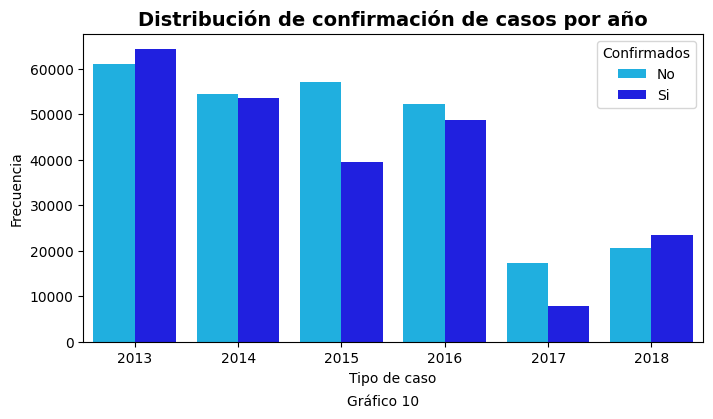

In [86]:
# Graficar
plt.figure(figsize=(8, 4))
sns.countplot(x="ANO", data = df, hue = "confirmados", legend = True, palette=["deepskyblue", "blue"])
plt.title("Distribución de confirmación de casos por año", fontsize=14, fontweight="bold")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de caso")
plt.legend(title = "Confirmados", labels = ["No", "Si"])
plt.figtext(0.5, -0.05, "Gráfico 10", ha="center", fontsize=10)
plt.show()

El *gráfico 10* muestra la distribución de la confirmación de casos por año en un periodo de $2013$ a $2018$. Se observa que la cantidad de casos confirmados sigue una tendencia decreciente de $2013$ a $2016$, con una caída abrupta en $2017$ y un ligero aumento en 2018.Por otro lado, en los años $2014$ al $2017$, la cantidad de casos *no* confirmados fue superior a la de casos confirmados.

## *Hospitalización*
Pacientes que requirieron hospitalización por enefermedad: (1) Hospitalizados (2) No Hospitalizados

In [96]:
# Pacientes hospitalizados

# Tabla
tabla_hosp = pd.DataFrame({
    "Hospitalizacion": df["PAC_HOS"].value_counts().index,
    "Pacientes": df["PAC_HOS"].value_counts().values,
})
tabla_hosp["Porcentaje"] = round((tabla_hosp["Pacientes"] / tabla_hosp["Pacientes"].sum()) * 100, 3)
print("Distribución de hospitalizados")
print(tabla_hosp)

Distribución de hospitalizados
   Hospitalizacion  Pacientes  Porcentaje
0                2     315801      63.104
1                1     184643      36.896


La mayor parte de los pacientes ($63.1$%), no fueron hospitalizados. Solo un $36.9$% requirio hospitalización.

### Hospitalización de pacientes por año

In [ ]:
# Pacientes hospitalizados por año|

#Tabla
tabla_hosp_year = df.groupby("ANO")["PAC_HOS"].value_counts().unstack().fillna(0)
tabla_hosp_year.columns = ["No Hospitalizado (2)", "Hospitalizado (1)"]

print("Cantidad de pacientes hospitalizados por año")
print(tabla_hosp_year)

Cantidad de pacientes hospitalizados por año
      No Hospitalizado (2)  Hospitalizado (1)
ANO                                          
2013                 49735              75819
2014                 39345              68630
2015                 34390              62054
2016                 30328              70688
2017                  9035              16249
2018                 21810              22361


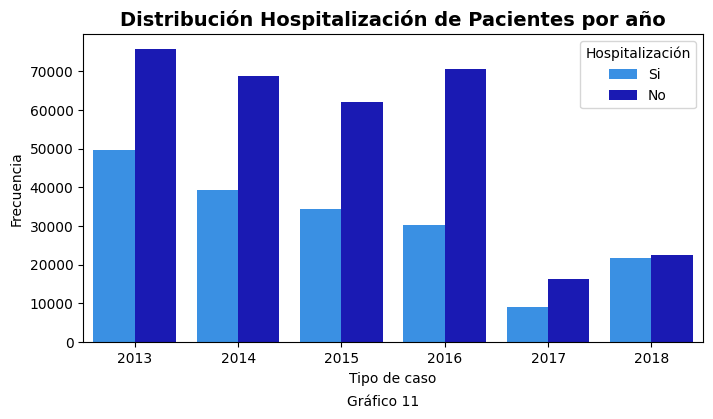

In [89]:
# Gráfica
plt.figure(figsize=(8, 4))
sns.countplot(x="ANO", data = df, hue = "PAC_HOS", legend = True, palette=["dodgerblue", "mediumblue"])
plt.title("Distribución Hospitalización de Pacientes por año", fontsize=14, fontweight="bold")
plt.ylabel("Frecuencia")
plt.xlabel("Tipo de caso")
plt.legend(title = "Hospitalización", labels = ["Si", "No"])
plt.figtext(0.5, -0.05, "Gráfico 11", ha="center", fontsize=10)
plt.show()

El *gráfico 11* muestra el comportamiento de hospitalización de pacientes por año. Entre $2013$ y $2015$, la cantidad de pacientes No Hospitalizados mostró una tendencia descendente hasta el $2016$. En contraste, la cantidad de pacientes hospitalizados presentó una disminución continua desde $2013$ hasta $2017$. Finalmente, en $2018$, ambos grupos alcanzaron un nivel similar, mostrando una distribución equitativa entre hospitalizados y no hospitalizados.

### Pacientes Hospitalizados por sexo

Text(0.5, -0.05, 'Gráfico 12')

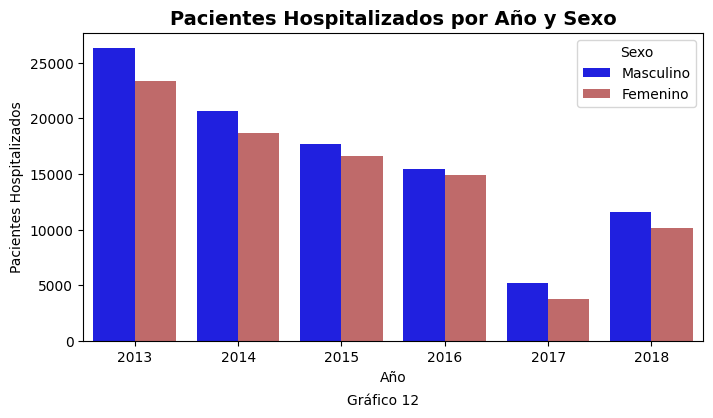

In [90]:
# Filtrar solo los pacientes hospitalizados
df_hosp = df[df['PAC_HOS'] == 1]

plt.figure(figsize=(8, 4))
sns.countplot(x="ANO", data = df_hosp, hue = "SEXO", legend = True, palette=["blue", "indianred"])
plt.title("Pacientes Hospitalizados por Año y Sexo", fontsize=14, fontweight="bold")
plt.xlabel("Año")
plt.ylabel("Pacientes Hospitalizados")
plt.legend(title = "Sexo", labels = ["Masculino", "Femenino"])
plt.figtext(0.5, -0.05, "Gráfico 12", ha="center", fontsize=10)

*Gráfico 12* muestra la distribución de pacientes hospitalizados según su sexo a lo largo de los años registrados. En **todos** los años, la cantidad de pacientes de sexo masculino supera notablemente a la de pacientes femeninos.

### Pacientes hospitalizados por evento

In [97]:
tabla = df.groupby("EVENTO")["PAC_HOS"].value_counts().unstack().fillna(0)
tabla.columns = ["No Hospitalizado (1)", "Hospitalizado (2)"]
print("Hospitalización de pacientes por evento")
print(tabla)

Hospitalización de pacientes por evento
              No Hospitalizado (1)  Hospitalizado (2)
EVENTO                                               
DENGUE                      176983             314654
DENGUE GRAVE                  7660               1147


# **Pruebas paramétricas**

## Prueba chi-cuadrado
Para la independencia de variables

In [92]:
def prueba_chi2(df, var1, var2, resultados):
    """
    Realiza la prueba de Chi-Cuadrado entre dos variables categóricas y almacena los resultados.
    
    Parámetros:
    df          - DataFrame con los datos.
    var1, var2  - Variables categóricas a analizar.
    resultados  - Lista donde se almacenan los resultados.
    """
    tabla = pd.crosstab(df[var1], df[var2])
    chi2, p, dof, expected = stats.chi2_contingency(tabla)
    decision = "Hay relación" if p < 0.05 else "No hay relación"
    resultados.append([var1, var2, round(chi2, 4), round(p, 4), decision])

resultados_chi2 = []
comparaciones = [
    ("PAC_HOS", "SEMANA"), ("PAC_HOS", "SEXO"), ("PAC_HOS", "EVENTO"), 
    ("CON_FIN", "PAC_HOS"), ("CON_FIN", "SEMANA"), ("CON_FIN", "SEXO"), ("CON_FIN", "EVENTO"),
    ("confirmados", "PAC_HOS"), ("confirmados", "CON_FIN"), ("confirmados", "SEXO"), ("confirmados", "SEMANA")
]
for var1, var2 in comparaciones:
    prueba_chi2(df, var1, var2, resultados_chi2)
tabla_resultados = pd.DataFrame(resultados_chi2, columns=["Variable 1", "Variable 2", "Chi2", "Valor p", "Decisión"])
print("Tabla cruzada prueba chi Cuadrado")
print(tabla_resultados)


Tabla cruzada prueba chi Cuadrado
     Variable 1 Variable 2        Chi2  Valor p         Decisión
0       PAC_HOS     SEMANA   1543.7076   0.0000     Hay relación
1       PAC_HOS       SEXO      0.5321   0.4657  No hay relación
2       PAC_HOS     EVENTO   9654.7541   0.0000     Hay relación
3       CON_FIN    PAC_HOS    281.7138   0.0000     Hay relación
4       CON_FIN     SEMANA    108.4131   0.3640  No hay relación
5       CON_FIN       SEXO      2.7500   0.2528  No hay relación
6       CON_FIN     EVENTO  12583.4615   0.0000     Hay relación
7   confirmados    PAC_HOS  20156.4926   0.0000     Hay relación
8   confirmados    CON_FIN     87.9502   0.0000     Hay relación
9   confirmados       SEXO    132.4649   0.0000     Hay relación
10  confirmados     SEMANA   1172.7880   0.0000     Hay relación


*Resultados:*

-**Hospitalización:**\
Está relacionada con la semana epidemiológica y el tipo de evento.
Puede indicar brotes en periodos del año. 

-**Condición final:**\
El desenlace final se ve afectada por la hospitalización y el evento.
Tasas de mortalidad por casos.

-**Casos confirmados:**\
La hospitalización está altamente relacionada con la confirmación de casos, así como la condición final. El sexo y la semana influyen en la cantidad de casos confirmados. 
El número de confirmados cambia según la semana y afecta la hospitalización y desenlace.

-**Sin relación:**\
El sexo no tiene impacto significativo en el desenlace final o en la hospitalización.
La semana no influye en el desenlace final. 

## Prueba U
Diferencia entre dias entre el inicio de simtomas, incidente en la hospitalización y la confirmación del caso.

In [93]:
def analizar_demora_consulta(df):
    """
    Calcula la demora en consulta, filtra casos con demora < 60 días
    y aplica la prueba de Mann-Whitney U para hospitalización y confirmación de casos.
    """
    df.loc[:, "Demora_Consulta"] = (df["FEC_CON"] - df["INI_SIN"]).dt.days
    df_filtrado = df[df["Demora_Consulta"] < 60].copy()

    def aplicar_prueba_mannwhitney(grupo1, grupo2, nombre_grupo):
        """Aplica la prueba de Mann-Whitney U y devuelve los resultados."""
        if len(grupo1) == 0 or len(grupo2) == 0:
            print(f"No hay suficientes datos para comparar {nombre_grupo}.")
            return None, None

        u_stat, p_valor = stats.mannwhitneyu(grupo1, grupo2, alternative="two-sided")
        print(f"\nPrueba Mann-Whitney U para {nombre_grupo}:")
        print(f"  Estadístico U: {u_stat}")
        print(f"  Valor p: {p_valor:.4f}")

        if p_valor < 0.05:
            print(f"  Diferencia significativa en la demora según {nombre_grupo}.")
        else:
            print(f"  No hay diferencia significativa en la demora según {nombre_grupo}.")
        
        return u_stat, p_valor

    # Comparación por hospitalización
    grupo_hosp = df_filtrado[df_filtrado["PAC_HOS"] == 1]["Demora_Consulta"].dropna()
    grupo_no_hosp = df_filtrado[df_filtrado["PAC_HOS"] == 2]["Demora_Consulta"].dropna()
    aplicar_prueba_mannwhitney(grupo_hosp, grupo_no_hosp, "Hospitalización")

    # Comparación por confirmación de casos
    grupo_conf = df_filtrado[df_filtrado["confirmados"] == 1]["Demora_Consulta"].dropna()
    grupo_no_conf = df_filtrado[df_filtrado["confirmados"] == 0]["Demora_Consulta"].dropna()
    aplicar_prueba_mannwhitney(grupo_conf, grupo_no_conf, "Confirmación de Casos")

# Llamar la función con el DataFrame
analizar_demora_consulta(df)


C:\Users\danie\AppData\Local\Temp\ipykernel_15072\2385012005.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Demora_Consulta"] = (df["FEC_CON"] - df["INI_SIN"]).dt.days



Prueba Mann-Whitney U para Hospitalización:
  Estadístico U: 31707588307.5
  Valor p: 0.0000
  Diferencia significativa en la demora según Hospitalización.

Prueba Mann-Whitney U para Confirmación de Casos:
  Estadístico U: 36757938149.5
  Valor p: 0.0000
  Diferencia significativa en la demora según Confirmación de Casos.


Los resultados de la prueba de **Mann-Whitney U** indican que existe una diferencia estadísticamente significativa en la demora en consulta según la hospitalización y la confirmación de casos (*p* < 0.05 en ambos casos). Esto sugiere que el tiempo transcurrido entre el inicio de los síntomas y la consulta médica varía de manera importante entre pacientes hospitalizados y no hospitalizados, así como entre casos confirmados y no confirmados.